# Исследование рынка компьютерных игр

**Описание проекта**

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

**Задача:** выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В ходе исследования будут проведены следующие *шаги*:

1. Изучение данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Составление портрета пользователя
5. Проверка гипотез

**Описание данных**
    
    Name — название игры
	Platform — платформа
	Year_of_Release — год выпуска
	Genre — жанр игры
	NA_sales — продажи в Северной Америке (миллионы проданных копий)
	EU_sales — продажи в Европе (миллионы проданных копий)
	JP_sales — продажи в Японии (миллионы проданных копий)
	Other_sales — продажи в других странах (миллионы проданных копий)
	Critic_Score — оценка критиков (максимум 100)
	User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг
    компьютерных игр и присваивает им подходящую возрастную категорию.

## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
except:
    data = pd.read_csv('D:\Файлы с ноута\! Аналитик данных (Яндекс)\МОДУЛЬ 1\Сборный Проект 1\games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


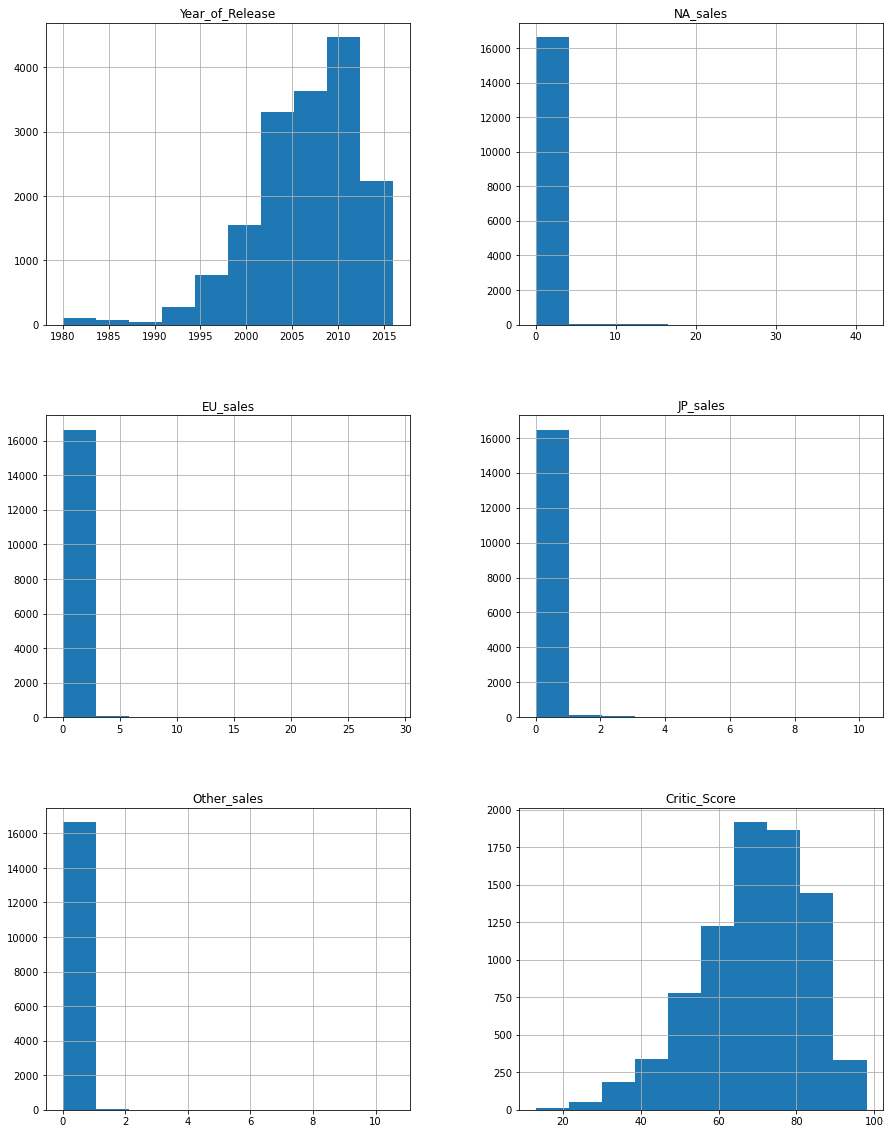

In [4]:
data.hist(figsize=(15,20));

In [5]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

## Предобработка данных

In [6]:
# приведем названия столбцов к нижнему регистру
data = data.rename(str.lower, axis='columns')

In [7]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,2.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.000000
user_score,40.000000


Датасет содержит 16715 строк. В 6 колонках из 11 есть пропущенных значения.

В колонке **year_of_release** отсутствуют данные в 2% строк. К сожалению, для данных по этим строкам нельзя найти логическую замену. К тому же, год - довольно важный признак для проводимого анализа. Поэтому от строк целесообразнее сразу избавиться.

Больше всего пропущенных значений в колонках **critic_score**, **user_score** и **rating** - доля пропусков в этих признаках достикает 40-51%. 

Для признаков **critic_score** и **user_score** можно было бы заполнить пропуски, например, медианой по жанру. Но это может исказить результаты корреляционного анализа и статистических тестов в дальнейшем. Поэтому правильнее, на мой взгляд, оставить эти признаки как есть.

А вот для категориального признака **rating** можно заменить пропущенные значения на "Unknown".

In [9]:
# удалим строки с NaN в столбце year_of_release
data = data.dropna(subset=['year_of_release'])
# заменим NaN на Unknown в столбце rating
data['rating'] = data['rating'].fillna('Unknown')

In [10]:
# посмотрим на две строки, в которых не указан жанр игры
data.query('genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,Unknown
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,Unknown


В колонках **name** и **genre** так же было пропущено по два значения. По срезу выше видно, что это одни и те же строки. Кроме того, в этих строках отсуствуют данные еще и по рейтингу, и по оценкам критиков и юзеров. Удалим их.

In [11]:
data = data.dropna(subset=['genre']).reset_index(drop=True)

In [12]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.000000
user_score,40.000000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


От части пропусков избавились, теперь необходимо обработать типы данных.

Года в **year_of_release** сейчас записаны, как *float*, хотя правильнее привести их к типу *int*.

In [14]:
data['year_of_release'] = data['year_of_release'].astype(int)

In [15]:
data['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [16]:
data.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
300,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
516,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
639,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
709,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16424,Planet Monsters,GBA,2001,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16426,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16427,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16433,Plushees,DS,2008,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


Оценки пользователей в колонке **user_score** имеют смешанный тип - часть значений представляют из себя дробные числа (тип *float*), часть значений это строковое значение 'tbd' (тип *str*). Из-за этого вся колонка имеет значение *object*.

'tbd' - аббревиатура от английского 'to be determined' (будет определено) или 'to be decided' (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. По сути, это тоже пропуски. Заменим их на NaN и приведем колонку к типу *float*.

In [17]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')
data['user_score'] = data['user_score'].astype(float)

In [18]:
# проверка на наличие явных дубликатов
data.duplicated().sum()

0

In [19]:
# Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB


**Вывод**

В ходе предобработки данных названия столбцов были приведены к snake_case, удалены строки с пропущенными значеними в колонках **name** и **year_of_release** (-1,6% данных), изменены типы данных в графах **year_of_release** и **user_score**, добавлена графа с суммарными продажами по всем регионам.

In [21]:
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Шаг 3. Исследовательский анализ данных


**Сколько игр выпускалось в разные годы**

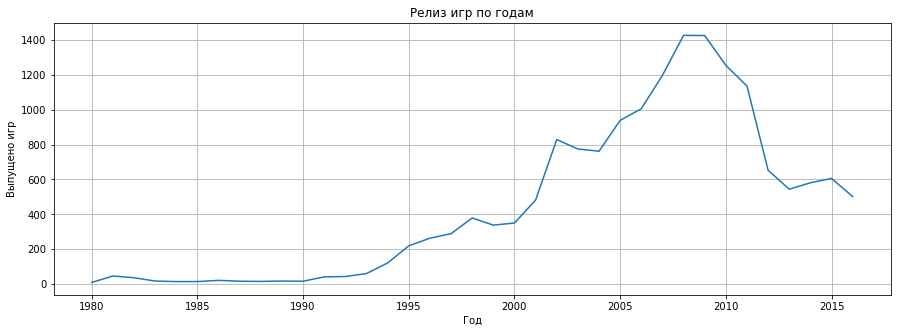

In [22]:
# постромим график релизов по годам
data.groupby('year_of_release')['name'].count().plot(style='-', figsize=(15,5))
plt.xlabel('Год')
plt.ylabel('Выпущено игр')
plt.title('Релиз игр по годам')
plt.grid()
plt.show()

In [23]:
data.groupby('year_of_release')['name'].count().sort_values(ascending=False).head(20)

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
Name: name, dtype: int64

Согласно имеющимся данным, расцвет игровой индустрии на начало 2000-х с пиком в 2008-2009 годах, когда выпускалось более 1400 игр в год. После 2010 года темп снизился - игры становились всё сложнее, теперь на их разработку уходит больше времени и в год выпускают меньше релизов.

**Посмотрим, как менялись продажи по платформам**

In [24]:
data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(10)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [25]:
top_platform_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']
top_platform_sales = data.query('platform in @top_platform_list and year_of_release > 1995')
top_platform_sales.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


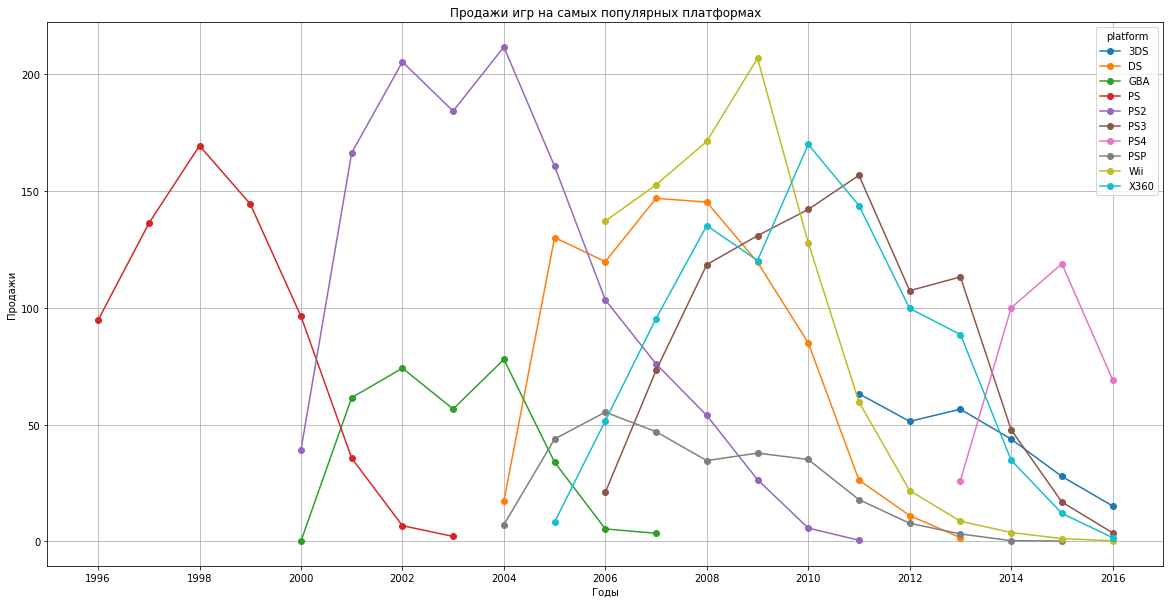

In [26]:
(
    top_platform_sales.pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum')
    .plot(style='o-', figsize=(20,10)).set_xticks([1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016])
)
plt.xlabel('Годы')
plt.ylabel('Продажи')
plt.title('Продажи игр на самых популярных платформах')
plt.grid()
plt.show()

In [27]:
# Оценим продолжительность жизни популярных платформ. Сначала создадим сводную таблицу
platform_life_time = top_platform_sales.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
# переименуем столбцы
platform_life_time.set_axis(['platform', 'first_year', 'last_year'], axis='columns', inplace=True)
# рассчитаем продолжительность жизни - вычтем из последнего года первый
platform_life_time['length'] = platform_life_time.last_year - platform_life_time.first_year
display(platform_life_time)
display(platform_life_time['length'].describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99]))

,platform,first_year,last_year,length
0,3DS,2011,2016,5
1,DS,2004,2013,9
2,GBA,2000,2007,7
3,PS,1996,2003,7
4,PS2,2000,2011,11
5,PS3,2006,2016,10
6,PS4,2013,2016,3
7,PSP,2004,2015,11
8,Wii,2006,2016,10
9,X360,2005,2016,11


count    10.000000
mean      8.400000
std       2.796824
min       3.000000
5%        3.900000
25%       7.000000
50%       9.500000
75%      10.750000
95%      11.000000
99%      11.000000
max      11.000000
Name: length, dtype: float64

Средняя продолжительность жизни популярных платформ составляет 8 лет. Из тех платформ, игры на которые продолжали продаваться в 2016 году, 5 платформ-долгожителей: PS3, Wii, PS2, PSP и X360. Наименьший срок жизни у 3DS и PS4 - эти платформы вышли в 2011 и 2013 годах соответственно. Пик популярности всех платформ приходится на середину их жизненного срока.

С учетом сложившейся динамики и продолжительности жизни актуальных платформ, для целей проводимого исследования данные до 2013 года рассматривать не целесообразно. Таким образом, в качестве актуального периода возьмем 2013-2016 года.

In [28]:
# создадим срез с данными за актуальный период
data_actual = data.query('year_of_release > 2012')
data_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


**Посмотрим какие платформы лидируют по продажам, растут или падают**

Дальнейший анализ будем производить на данных за актуальный период 2013-2016 года. 

In [29]:
data_actual['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

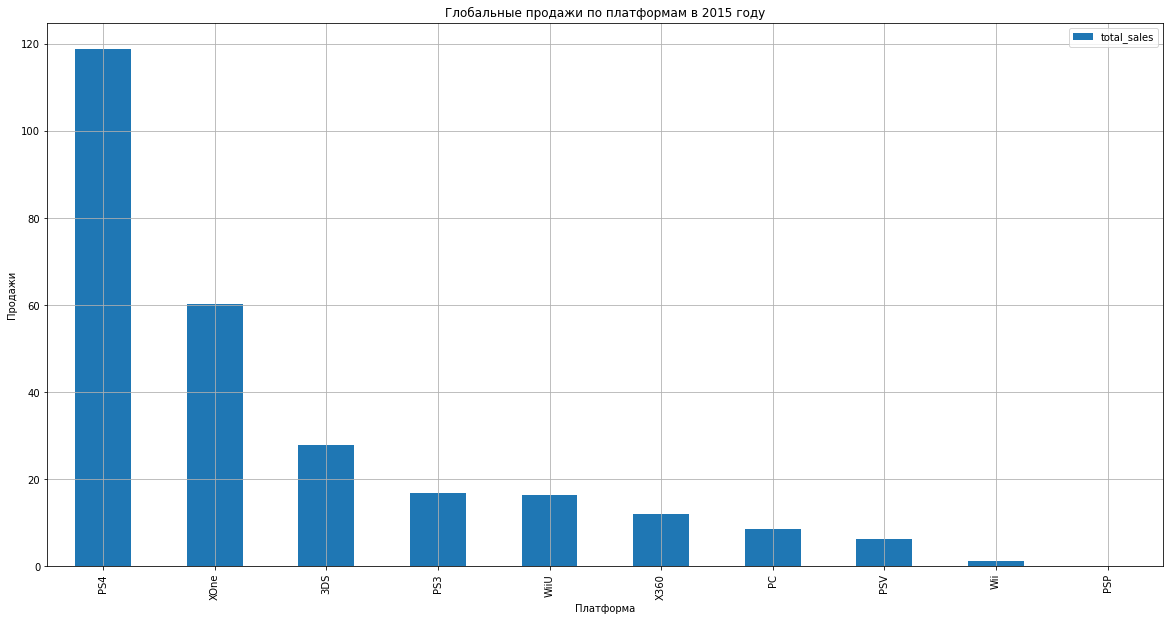

In [30]:
# на основе данных за 2015 год определим топ популярных платформ (согласно описанию, данные за 2016 год могут быть не полными).
(
    data_actual.query('year_of_release == 2015')
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False).plot(kind='bar', figsize=(20,10))
)
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Глобальные продажи по платформам в 2015 году')
plt.grid()
plt.show()

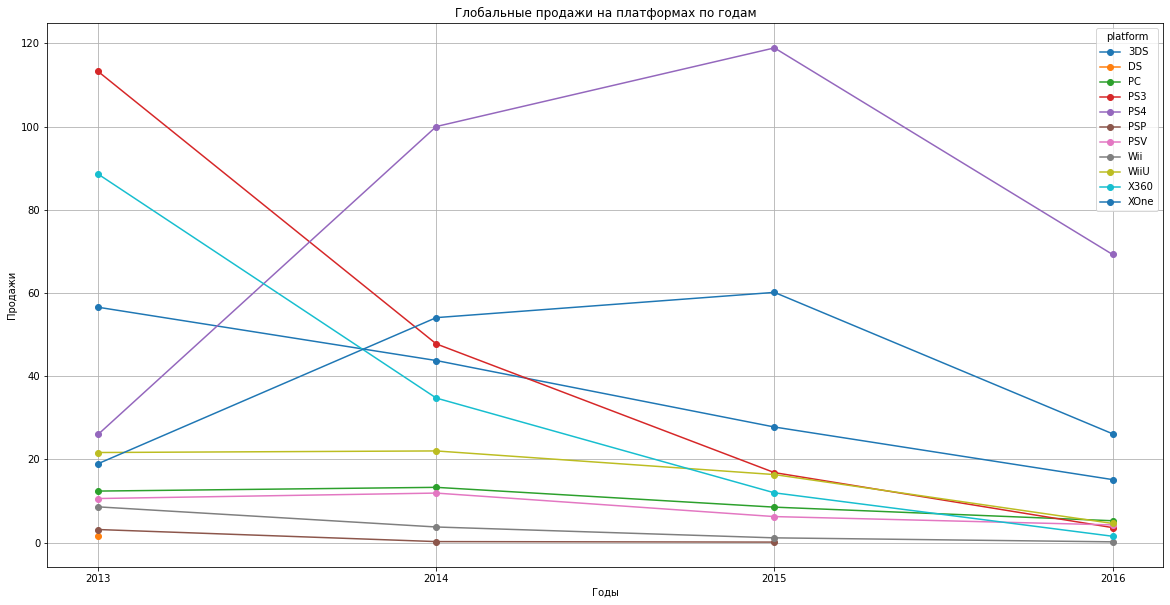

In [31]:
(
    data_actual.pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum')
    .plot(style='o-', figsize=(20,10)).set_xticks([2013, 2014, 2015, 2016])
)

plt.xlabel('Годы')
plt.ylabel('Продажи')
plt.title('Глобальные продажи на платформах по годам')
plt.grid()
plt.show()

На графиках видно, что PS4, WiiU и XBox One находятся на подъеме; Nintendo 3DS, XBox 360, PS3 и PSV миновали пик популярности; Wii и PSP отжили свое, а персональные компьютеры (PC) держатся на плаву. По совокупности факторов, для дальнейшего анализа оставим наиболее перспективные платформы - PS4, WiiU, XBox One, Nintendo 3DS и PC.

**Построим «ящики с усами» по глобальным продажам игр по выбранным платформам**

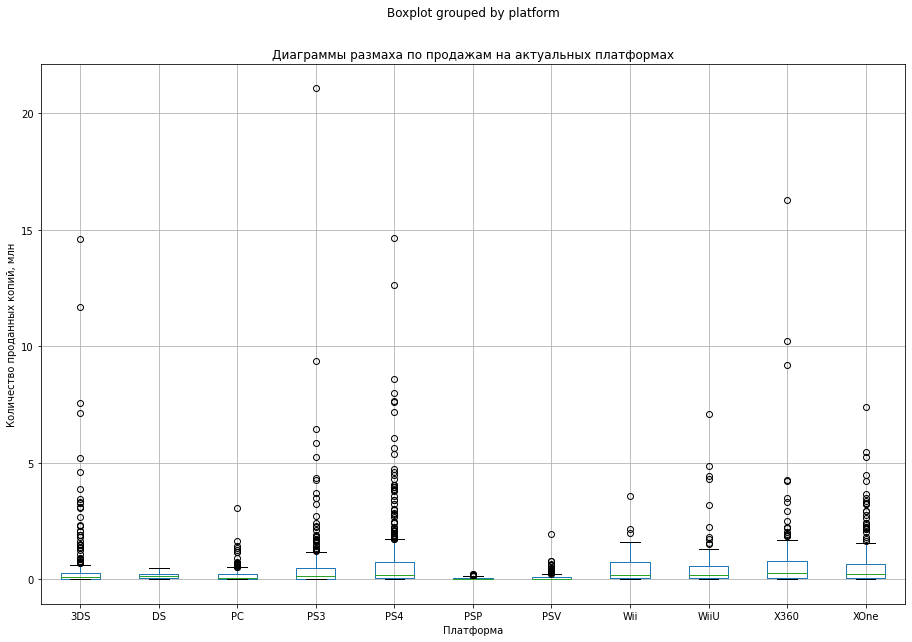

In [32]:
(data_actual.boxplot(column='total_sales', by='platform', figsize=(15,10))
)
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий, млн')
plt.title('Диаграммы размаха по продажам на актуальных платформах')
#plt.ylim(0, 4)
plt.show()

У всех платформ, кроме DS, есть выбросы и весьма многочисленные. По отдельным платформам были зафиксированы необыччайно высокие продажи на более чем 10 и даже 15 миллионов копий (PS4 и XBox 360). Вероятно, это какие-то супер-хиты, сделавшие свои платформы мегапопулярными в свое время. Основная же масса выбросов располагается до отметки в 5 миллионов копий. Удалять эти выбросы не будем, а посмотрим поближе на сами коробки.

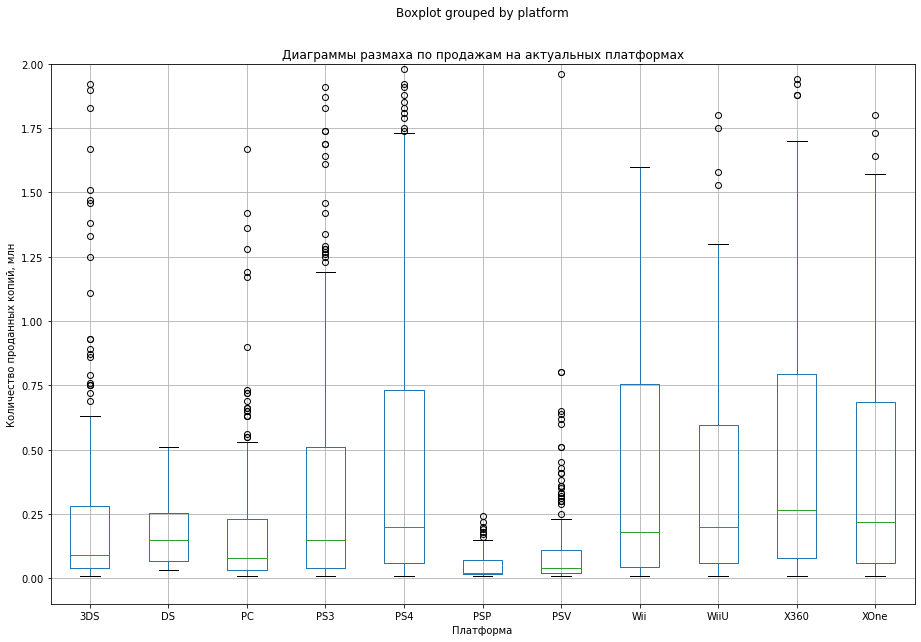

In [33]:
(data_actual.boxplot(column='total_sales', by='platform', figsize=(15,10))
)
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий, млн')
plt.title('Диаграммы размаха по продажам на актуальных платформах')
plt.ylim(-0.1, 2)
plt.show()

У PS4 самый большой размах продаж по годам, она же лидирует и в динамике - на второй год после выпуска продажи игр для этой платформы выросли почти вдвое.

Персональные компьютеры (PC) демонстрирует довольно узкий размах и плавную динамику к снижению, что говорит о, возможно, не высокой популярности, но стабильном спросе на игры для этого вида платформ.

Выбросы на графиках показывают, что у каждой из платформ случаются супер-хиты, приносящие миллионы - таких успешных проектов больше всего у PS4 и XBox One. А вот у Nintendo 3DS маленький ящик и очень много выбросов. Можно предположить, что минимум половина продаж по этой платформе обусловлена этими выбросами.

График размаха у XBox One похож на размах PS4: большой бокс, длинный ус и относительно немного выбросов. Это свидетельствует о том, что на XBox One спросом у потребителей пользуются самые разные игры.

Совсем нет выбросов Nintendo DS - у этой платформы не было каких-то хитовых релизов, но она, как и PC, показывает стабильный спрос у пользователей.

PSP и PSV имеют самые маленькие размахи, продажи по этим платформам как правило не превышают 250 тыс копий. Но у PSV чаще случаются хиты.

В целом, ни у одной из платформ средние продажи не превышают 500 тыс копий. Только 6 платформ показали в актуальном периоде стабильные продажи более миллиона и только у четырех из них (PS4, Wii, XBox 360, XBox One) такие продажи превышают полтора миллиона копий.

**Изучим влияние отзывов на продажи игр для популярных платформ**

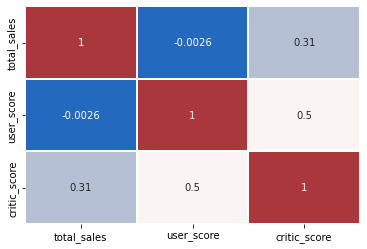

In [34]:
# построим общую матрицу корреляции
sns.heatmap(data_actual[['total_sales', 'user_score', 'critic_score']].corr(), annot=True, cmap='vlag', cbar=False, robust=True, linewidths=.2)
plt.show()

Судя по матрице корреляции, продажи имеют хоть сколько бы то ни было значимую связь только с оценками критиков. Оценки же пользователей на продажи не влияют. При этом существует устойчивая прямая корреляция между оценками критиков и пользователей.

Посмотрим, как влияют отзывы пользователей и критиков на продажи внутри каждой платформы.

In [35]:
# сохраним список актуальных платформ на будущее
actual_platforms = ["PS4", "WiiU", "XOne", "PC", "3DS"]

PS4


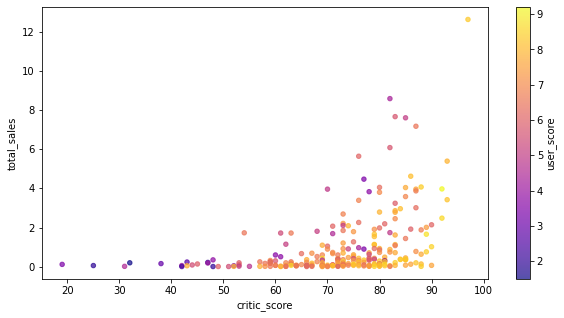

WiiU


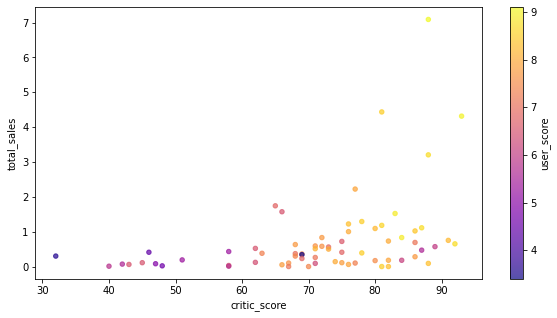

XOne


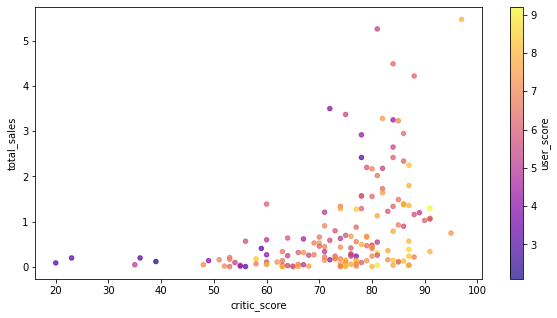

PC


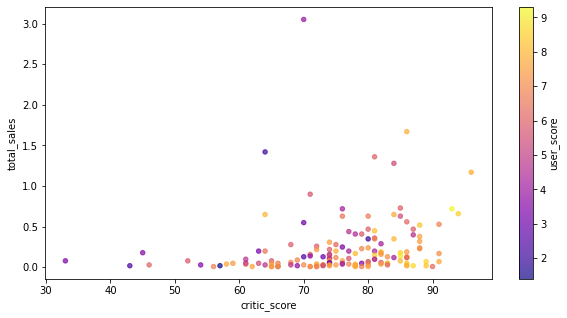

3DS


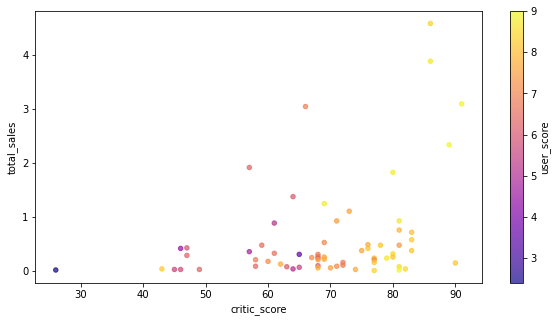

In [36]:
for i in actual_platforms:
    print(i)
    data_select = data_actual.query('platform == @i')
    data_select.plot.scatter('critic_score',  'total_sales', figsize=(10, 5), alpha=0.7, c='user_score', colormap='plasma', sharex=False)
    plt.show()

PS4


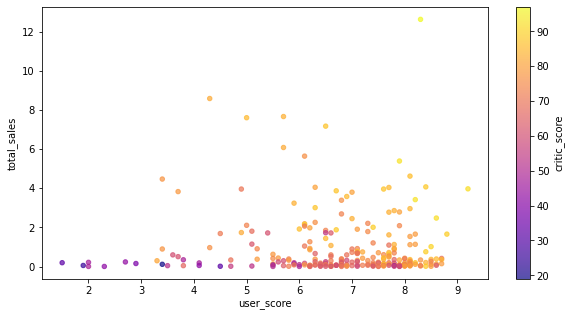

WiiU


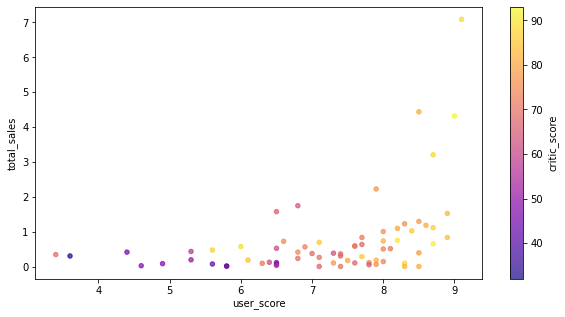

XOne


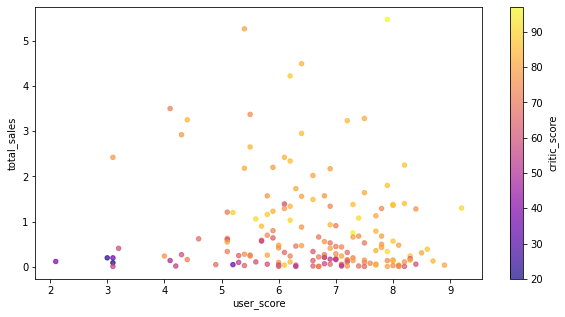

PC


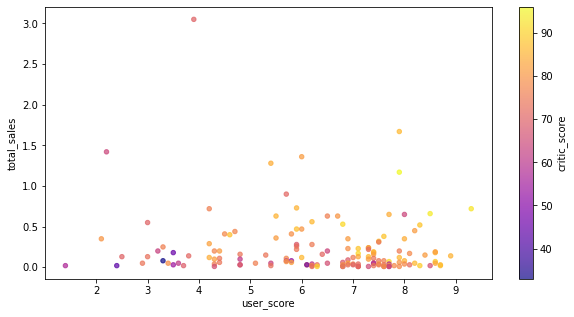

3DS


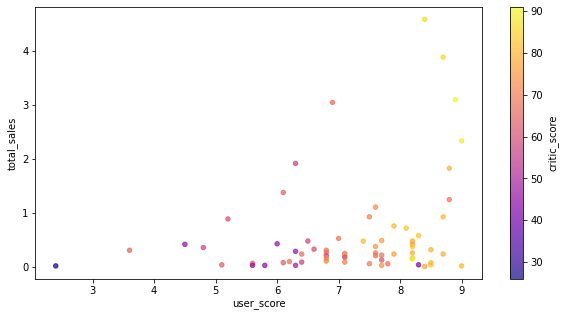

In [37]:
# диаграммы рассеяния по отзывам пользователей
for i in actual_platforms:
    print(i)
    data_select = data_actual.query('platform == @i')
    data_select.plot.scatter('user_score',  'total_sales', figsize=(10, 5), alpha=0.7, c='critic_score', colormap='plasma', sharex=False)
    plt.show()

In [38]:
# Расчет корреляции по каждой платформе
for p in ['PS4', 'Wii', '3DS', 'PC', 'PS3']:
    print(p)
    data_select = data.query('platform == @p')
    print(f'Корреляция между оценкой критиков и продажами: {data_select.critic_score.corr(data_select.total_sales):.2}')
    print(f'Корреляция между оценкой пользователей и продажами: {data_select.user_score.corr(data_select.total_sales):.2}')
    print(f'Корреляция между оценками критиков и пользователей: {data_select.critic_score.corr(data_select.user_score):.2}')
    print('--' * 30)

PS4
Корреляция между оценкой критиков и продажами: 0.41
Корреляция между оценкой пользователей и продажами: -0.032
Корреляция между оценками критиков и пользователей: 0.56
------------------------------------------------------------
Wii
Корреляция между оценкой критиков и продажами: 0.18
Корреляция между оценкой пользователей и продажами: 0.11
Корреляция между оценками критиков и пользователей: 0.69
------------------------------------------------------------
3DS
Корреляция между оценкой критиков и продажами: 0.35
Корреляция между оценкой пользователей и продажами: 0.22
Корреляция между оценками критиков и пользователей: 0.75
------------------------------------------------------------
PC
Корреляция между оценкой критиков и продажами: 0.26
Корреляция между оценкой пользователей и продажами: 0.013
Корреляция между оценками критиков и пользователей: 0.56
------------------------------------------------------------
PS3
Корреляция между оценкой критиков и продажами: 0.43
Корреляция между о

На примере PS4 видно, что чем выше оценка критиков, тем выше продажи. Линейная корреляция сильнее между продажами и оценками критиков, а вот между продажами и оценками пользователей корреляция не только очень слабая, но и обратная. 

По остальным платформам картина похожая, хотя есть вариации. Например, у Nintendo Wii продажи одинаково слабо коррелируют как с оценками критиков, так и с оценками пользователей. Похожая картина и с Nintendo 3DS - коэффициенты корреляции между продажами и оценкой пользователей и между продажами и оценкой критиков получились очень близкими. По всей видимости, на продажи игр для платформ марки Nintendo влияют другие факторы.

Примечательно, что игры, получившие высокие оценки критиков, довольно часто имеют средние оценки пользователей и наоборот. Логично предположить, что при построении прогноза продаж целесообразнее ориентироваться на оценки критиков нежели пользователей.

**Распределение игр по жанрам**

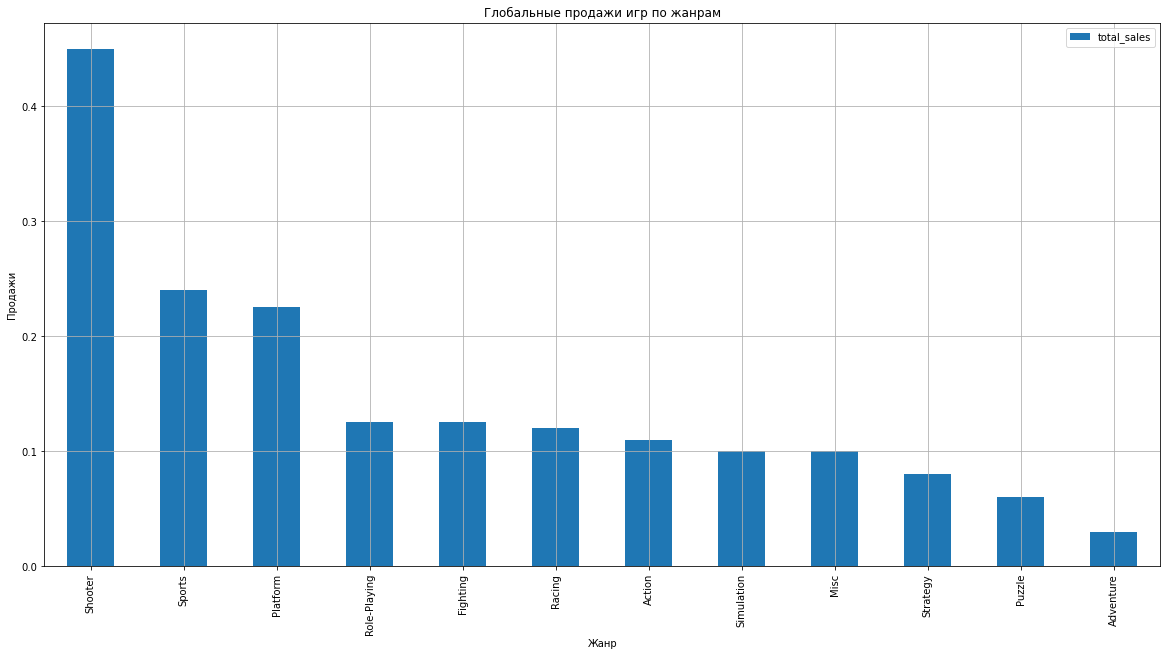

In [39]:
(
    data_actual.pivot_table(index='genre', values='total_sales', aggfunc='median')
    .sort_values(by='total_sales', ascending=False).plot(kind='bar', figsize=(20,10))
)
plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.title('Глобальные продажи игр по жанрам')
plt.grid()
plt.show()

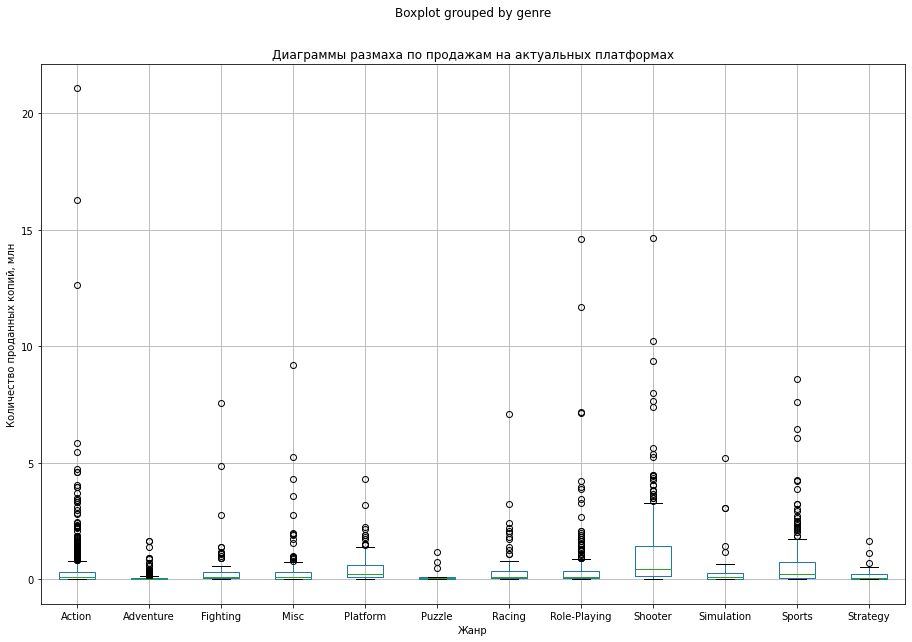

In [40]:
(data_actual.boxplot(column='total_sales', by='genre', figsize=(15,10))
)
plt.xlabel('Жанр')
plt.ylabel('Количество проданных копий, млн')
plt.title('Диаграммы размаха по продажам на актуальных платформах')
plt.show()

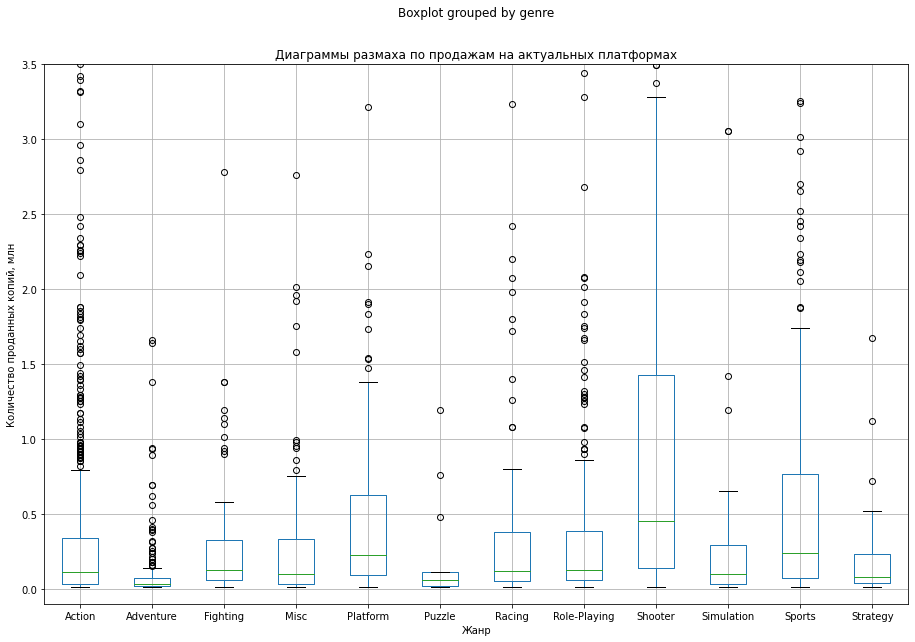

In [41]:
(data_actual.boxplot(column='total_sales', by='genre', figsize=(15,10))
)
plt.xlabel('Жанр')
plt.ylabel('Количество проданных копий, млн')
plt.title('Диаграммы размаха по продажам на актуальных платформах')
plt.ylim(-0.1, 3.5)
plt.show()

Самые высокие медианные продажи в актуальном периоде показали игры в жанре Shooter (более 400 тыс копий). Затем идут Sports и Platform (более 200 тыс копий каждый), далее Role-Playing, Fighting, Racing, Action (более 100 тыс копий каждый), Misc и Simulation (по 100 тыс копий каждый). Меньше всего продаж (менее 100 тыс копий) у Strategy, Puzzle и Adventure.

У лидеров так же и самый большой размах: у Shooter стаибильные продажи превышают 3 млн копий, у Sports - 1,5 млн копий, у Platform - чуть меньше 1,5 млн копий. 

Все жанры имеют многочисленные выбросы. Причем в отдельных жанрах есть супер-хиты, продававшиеся более чем на 10 млн копий (Action, Role-Playing и Shooter). Основная же масса выбросов лежит в пределах 5 млн копий.

**Вывод**

Средняя продолжительность жизни популярных платформ составляет 8 лет. Наиболее популярные платформы - PS4, WiiU, XBox One, Nintendo 3DS и PC. Самые популярные жанры игр это Shooter, Sports и Platform, а самые маловостребованные - Strategy, Puzzle и Adventure.

## Портрет пользователя из каждого региона

**Определим топ-5 платформ по каждому региону**

In [42]:
display(data_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head())
display(data_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head())
display(data_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head())

,na_sales
platform,
PS4,108.74
XOne,93.12
X360,81.66
PS3,63.50
3DS,38.20


,eu_sales
platform,
PS4,141.09
PS3,67.81
XOne,51.59
X360,42.52
3DS,30.96


,jp_sales
platform,
3DS,67.81
PS3,23.35
PSV,18.59
PS4,15.96
WiiU,10.88


В Северной Америке и Европе в топ-5 плаформ вошли одни и те же модели - это XBox 360, XBox One, 3DS, PS3 и PS4. И там, и там первую строчку занимает PS4. А вот второе место отличется - если в Америке второй по популярности консолью является XBox One, то в Европе второй по популярности платформой является PS3, которая сдвинула XBox One на третье место.

В Японии же XBox One даже не вошла в топ-5. Лидером японского рынка является 3DS, которая в Евроме и Северной Америке занимает только 5 место. Лидер европейского и североамериканского рынков - PS4 - в Японии занимает только четвертую строчку. Примечательно, что в топ-5 платформ в Японии вошли консоли исключительно японских брендов Nintendo и Sony, а американский бренд Microsoft, производящий линейку XBox, остался за бортом.

Так же интересно, что в Европе и Северной Америке первые четыре места занимают стационарные консоли, в то время как в Японии в топ-5 вошли преимущественно мобильные консоли. Это может быть связано с привычкой японцев экономить место в своих жилищах - портативные мобильные консоли можно хранить в тумбочке и тем самым не захламлять и без того ограниченное пространство комнаты. А вот в западных странах место экономить не принято, поэтому и приставку можно поставить стационарную.

**Определим топ-5 жанров по каждому региону**

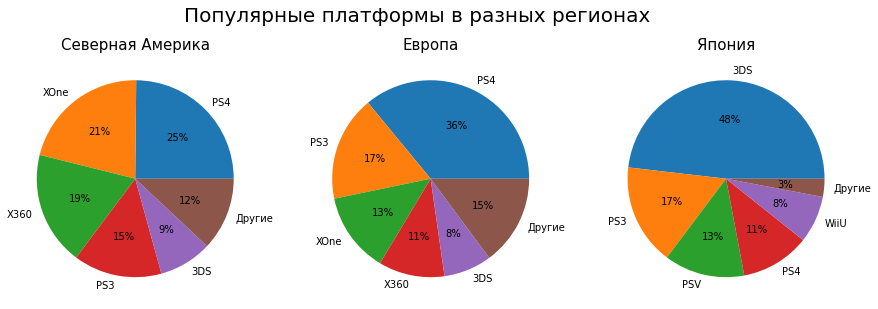

In [43]:
#import warnings
#warnings.filterwarnings('ignore')

countries = data_actual.columns[4:7]

fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Популярные платформы в разных регионах', fontsize = 20)
title = ['Северная Америка', 'Европа', 'Япония']

for i in range(3):
    df_i = (data_actual.groupby('platform')[countries[i]].sum().
           reset_index().
           sort_values(countries[i], ascending = False, ignore_index = True).
           head())
    df_i = df_i.append({'platform': 'Другие', countries[i]: data_actual[countries[i]].sum() - \
                       df_i[countries[i]].sum()}, ignore_index=True)
    axs[i].pie(df_i[countries[i]], labels = df_i['platform'], autopct='%1.0f%%')
    axs[i].set_title(title[i], fontsize = 15)
plt.show;

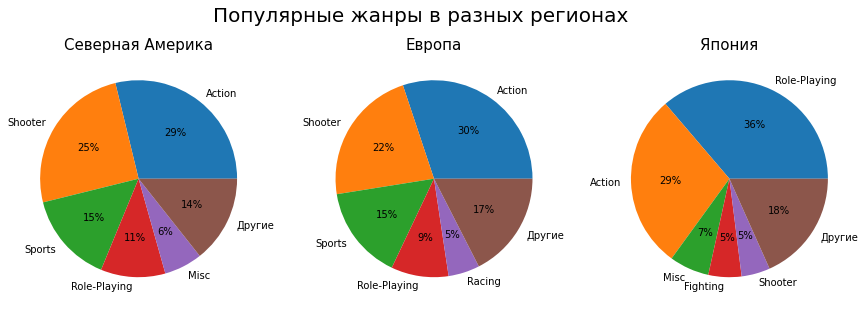

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Популярные жанры в разных регионах', fontsize = 20)
title = ['Северная Америка', 'Европа', 'Япония']

for i in range(3):
    df2_i = (data_actual.groupby('genre')[countries[i]].sum().
           reset_index().
           sort_values(countries[i], ascending = False, ignore_index = True).
           head())
    df2_i = df2_i.append({'genre': 'Другие', countries[i]: data_actual[countries[i]].sum() - \
                       df2_i[countries[i]].sum()}, ignore_index=True)
    axs[i].pie(df2_i[countries[i]], labels = df2_i['genre'], autopct='%1.0f%%')
    axs[i].set_title(title[i], fontsize = 15)
plt.show;

Первые четыре строчки на европейском и североамериканском рынках занимают жанры Action, Shooter, Sports и Role-Playing.

В Японии же распределение по жанрам принципиально другое - Action только на втором месте, Shooter на пятом, а лидером является жанр Role-Playing. Так же в японский топ вошли игры в жанре Fighting, которых не было в рейтингах Европы и Северной Америки.

Получается, что пользователи в Европе и Северной Америке предпочитают стрельбу, боевики и спортивные симуляторы в то время как японцы склонны к ролевым играм и аркадам. Вероятно, причина отличий в предпочтениях пользователей кроется в сложившихся культурно-исторических различиях между западной и восточной культурами.

**Посмотрим на влияние рейтинга ESRB на продажи в отдельных регионах**

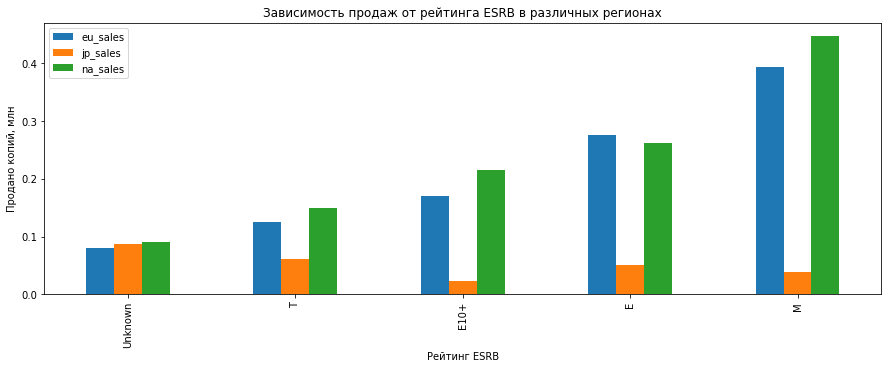

In [45]:
 (
    data_actual.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='mean')
    .sort_values(by='na_sales')
    .plot(kind='bar', figsize=(15, 5))
)
plt.xlabel('Рейтинг ESRB')
plt.ylabel('Продано копий, млн')
plt.title('Зависимость продаж от рейтинга ESRB в различных регионах')
plt.show()

В Европе и Северной Америке самыми популярными являются игры с рейтингом М (для взрослых) и Е (для всех), что хорошо соотносится с популярными в этих регионах жанрами Action и Shooting. 

В Японии же больше всего продается игр без рейтинга. Скорее всего, это связано с тем, что сам рейтинг ESRB создан и применяется для игр, выпускаемых на рынок Северной Америки. Поэтому, игры, выпускаемые для японского рынка, просто не получают рейтинг ESRB, но пользуются популярностью у местных пользователей.

**Вывод**

Вкусы пользователей из Европы и Северной Америки практически идентичны - и те, и другие предпочитают стационарные приставки и игры в жанрах Action и Shooting.

Предпочтения пользователей из Японии отличаются - жители страны восходящего солнца предпочитают мобильные консоли и игры в жанре Role-Playing местного производства.

## Проверка гипотез

**Гипотеза 1:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

*Нулевая гипотеза*: средний рейтинг Xbox One = средний рейтинг PC 

*Альтернативная гипотеза*: средний рейтинг Xbox One ≠ средний рейтинг PC 

Критический уровень статистической значимости примем равным 5%.

In [46]:
alpha = .05
results = st.ttest_ind(
    data_actual[(data_actual.platform == "XOne") & (data_actual.user_score.notna())]['user_score'], 
    data_actual[(data_actual.platform == "PC") & (data_actual.user_score.notna())]['user_score']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза подтвердилась, средние пользовательские рейтинги платформ Xbox One и PC не отличаются.

**Гипотеза 2:** Средние пользовательские рейтинги жанров Action и Sports разные

*Нулевая гипотеза*: средний рейтинг Action = средний рейтинг Sports 

*Альтернативная гипотеза*: средний рейтинг Action ≠ средний рейтинг Sports 

Критический уровень статистической значимости так же примем равным 5%.

In [47]:
alpha = .05 
results = st.ttest_ind(
    data_actual[(data_actual.genre == "Action") & (data_actual.user_score.notna())]['user_score'], 
    data_actual[(data_actual.genre == "Sports") & (data_actual.user_score.notna())]['user_score']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


По имеющимся данным, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений пользовательских рейтингов (отзывов) жанров Action и Sports в пользу альтернативной гипотезы.

**Вывод**

Обе гипотизы подтвердились: средние пользовательские рейтинги платформ Xbox One и PC равны, а вот средние пользовательские рейтинги жанров Action и Sports различаются.

In [48]:
# проверим наши выводы
display(data_actual.query('platform in ["XOne", "PC"]')
        .pivot_table(index='platform', values='user_score', aggfunc=['count', 'mean', 'median']))
display(data_actual.query('genre in ["Action", "Sports"]')
        .pivot_table(index='genre', values='user_score', aggfunc=['count', 'mean', 'median']))

,count,mean,median
,user_score,user_score,user_score
platform,,,
PC,155,6.269677,6.8
XOne,182,6.521429,6.8


,count,mean,median
,user_score,user_score,user_score
genre,,,
Action,389,6.837532,7.1
Sports,160,5.238125,5.5


## Общий вывод

**Описание проекта:**

Из открытых источников доступны исторические данные о продажах игр, оценках пользователей и экспертов, жанрах и платформах (например, Xbox или PlayStation). 

**Задача:** выявить определяющие успешность игры закономерности. 
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Исследование состояло из следующих этапов:
 1. Изучение данных
 2. Предобработка данных
 3. Исследовательский анализ данных
 4. Составление портрета пользователя
 5. Проверка гипотез

**Исходные данные** содержали 16 715 строк и 11 колонок (признаков). Часть значений была пропущена (до 40-50% в отдельных признаках), в колонке с оценками пользователей (user_score) присурствовало более 2000 тысяч записей со значением 'tbd' (от англ. 'to be determined' - будет определено), которые, по сути, так же являлись пропусками и были изменены на значения NaN.

В результате **предобработки данных** названия столбцов были приведены к snake_case; удалено 1,6% данных из-за пропущенных значений, которые невозможно было восстановить без потери смысла; изменены типы данных в отдельных графах; добавлена колонка с суммарными продажами игр по всем регионам. После проведенных операций в датасете стало 16 444 строки и 12 колонок.

**Исследовательский анализ данных** выявил следующие закономерности:

  - Расцвет игровой индустрии приходился на начало 2000-х годов с пиком в 2008-2009 годах. После 2010 года темп снизился - игры становились всё сложнее, теперь на их разработку уходит больше времени и в год выпускают меньше релизов.
  - Средняя продолжительность жизни популярных платформ составляет 8 лет. Пик популярности всех платформ приходится на середину их жизненного срока.
  - Наиболее перспективные платформы - PS4, WiiU, XBox One, Nintendo 3DS и PC (персональные компьютеры).
  - Персональные компьютеры (PC) не демонстрируют высокой популярности, но показывают стабильный спрос на игры для этого вида платформ.
  - У каждой из платформ случаются супер-хиты, приносящие миллионы. Больше всего успешных проектов у PS4 и XBox One.
  - Чем выше оценка критиков, тем выше продажи. 
  - Игры, получившие высокие оценки критиков, часто имеют средние оценки пользователей и наоборот.
  - Самые продаваемые жанры игр в настоящее время являются Shooter (медианные продажи более 400 тыс копий). Вторыми по популярности являются Sports и Platform (медианные продажи более 200 тыс копий).
  - Меньше всего покупают игры в жанрах Strategy, Puzzle и Adventure (медианные продажи менее 100 тыс копий).
  - На пользовательские оценки влияет жанр игры, а тип платформы - нет.

В ходе исследования были сформулированы **портреты пользователей**:

Вкусы ***пользователей из Европы и Северной Америки*** практически идентичны. В обоих регионах предпочитают стационарные игровые платформы - в топ-5 вошли XBox 360, XBox One, 3DS, PS3 и PS4. Так же и с жанрами - первые строчки на европейском и североамериканском рынках занимают жанры Action, Shooter и Sports. Чаще других в Европе и Северной Америке покупают игры с рейтингом М (для взрослых старше 17 лет) и Е (для всех).

***Пользователи из Японии***, напротив, отдают предпочтение мобильным консолям: Nintendo 3DS, PSV, Nintendo WiiU. В топ-5 платформ вошли только две стационарные модели (PS3 и PS4). По части жанров японские зрители предпочитают Role-Playing, Action и Misc (аркады). В целом, можно сказать, что японские пользователи весьма патриотичны - они предпочитают игровые платформы, выпущенные японскими компаниями, и игры, разработанные локальными фирмами специально для японского рынка.




При планировании рекламных бюджетов целесообразно ориентироваться на следующие закономерности:
 1. Самые перспективные платформы для продвижения - PS4, XBox One и Nintendo 3DS.
 2. Вкусы пользователей из Европы и Северной Америки существенно отличаются от вкусов пользователей из Японии. Поэтому целесообразнее ориентироваться на более крупный и однородный в плане предпочтений западный рынок.
 3. Наибольшей популярностью на рынках Европы и Северной Америки пользуются игры в жанрах Shooter, Action и Sports с возрастными рейтингами М (для взрослых) и Е (для всех).
 4. При выборе игр для продвижения следует смотреть на оценки критиков - чем они выше, тем выше и продажи игры.